In [25]:
import os
import snirf
import numpy as np
import pandas as pd

# %matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from typing import Union
from statistics import mean
from behav_analysis import Participant_Behav, load_results
from data_functions import Data_Functions


class Process_Flow:
    """
    This class contains functions for processing Kernel Flow data.
    Wrapper around an snirf.Snirf object.
    """

    def __init__(self, filepath: str) -> None:
        """
        Initialize by loading SNIRF file.

        Args:
            filepath (str): Path to SNIRF file.
        """
        self.data_fun = Data_Functions()
        self.snirf_file = self.load_snirf(filepath)

    def load_snirf(self, filepath: str) -> snirf.Snirf:
        """
        Load SNIRF file.

        Args:
            filepath (str): Path to SNIRF file.

        Returns:
            snirf.Snirf: SNIRF file object.
        """
        return snirf.Snirf(filepath, "r+", dynamic_loading=True)

    def get_time_origin(
        self, fmt: str = "datetime", offset=True
    ) -> Union[datetime.datetime, float]:
        """
        Get the time origin (start time) from the SNIRF file.

        Args:
            fmt (str, optional): Format to get the time origin in: "datetime" or "timestamp". Defaults to "datetime".
            offset (bool): Offset the datetime by 4 hours. Defaults to True.

        Raises:
            Exception: Invalid fmt argument.

        Returns:
            Union[datetime.datetime, float]:
                datetime.datetime: Time origin datetime.
                -or-
                float: Time origin timestamp.
        """
        start_date = self.snirf_file.nirs[0].metaDataTags.MeasurementDate
        start_time = self.snirf_file.nirs[0].metaDataTags.MeasurementTime
        start_str = start_date + " " + start_time
        if offset:
            time_origin = datetime.datetime.strptime(
                start_str, "%Y-%m-%d %H:%M:%S"
            ) - datetime.timedelta(
                hours=4
            )  # 4 hour offset
        else:
            time_origin = datetime.datetime.strptime(start_str, "%Y-%m-%d %H:%M:%S")
        if fmt.lower() == "datetime":
            return time_origin
        elif fmt.lower() == "timestamp":
            return datetime.datetime.timestamp(time_origin)
        else:
            raise Exception(
                "Invalid 'fmt' argument. Must be 'datetime' or 'timestamp'."
            )

    def get_subject_ID(self) -> str:
        """
        Get the subject ID from the SNIRF file.

        Returns:
            str: Subject ID.
        """
        return self.snirf_file.nirs[0].metaDataTags.SubjectID

    def get_time_rel(self) -> np.ndarray:
        """
        Get the relative time array from the SNIRF file.

        Returns:
            np.ndarray: Relative time array.
        """
        return self.snirf_file.nirs[0].data[0].time

    def get_time_abs(self, fmt: str = "datetime") -> np.ndarray:
        """
        Convert relative time array into an absolute time array.

        Args:
            fmt (str, optional): Format to get the time array in: "datetime" or "timestamp". Defaults to "datetime".

        Returns:
            np.ndarray: Absolute time array.
        """
        time_rel = self.get_time_rel()
        if fmt.lower() == "datetime":
            time_origin_dt = self.get_time_origin("datetime")
            return np.array(
                [
                    datetime.timedelta(seconds=time_rel[i]) + time_origin_dt
                    for i in range(len(time_rel))
                ]
            )
        elif fmt.lower() == "timestamp":
            time_origin_ts = self.get_time_origin("timestamp")
            return time_rel + time_origin_ts

    def get_data(
        self, fmt: str = "array", cols: list[int | list | tuple] = None
    ) -> Union[np.ndarray, pd.DataFrame]:
        """
        Get timeseries data from the SNIRF file.

        Args:
            fmt (str): Format of data (np.ndarray or pd.DataFrame). Defaults to "array".
            cols (list[int | list | tuple]): Data cols to select. Single col, list of cols, or slice of cols.
                                             Defaults to None (all columns).

        Raises:
            Exception: Invalid fmt argument.

        Returns:
            np.ndarray: Timeseries data array.
        """
        if cols or cols == 0:
            if isinstance(cols, tuple):
                data = (
                    self.snirf_file.nirs[0].data[0].dataTimeSeries[:, cols[0] : cols[1]]
                )
            else:
                data = self.snirf_file.nirs[0].data[0].dataTimeSeries[:, cols]
        else:
            data = self.snirf_file.nirs[0].data[0].dataTimeSeries

        if "array" in fmt.lower():
            return data
        elif "dataframe" in fmt.lower():
            return pd.DataFrame(data)
        else:
            raise Exception("Invalid fmt argument. Must be 'array' or 'dataframe'.")

    def get_source_pos_2d(self) -> np.ndarray:
        """
        Get the 2D source position array.

        Returns:
            np.ndarray: 2D source position array
        """
        return self.snirf_file.nirs[0].probe.sourcePos2D

    def get_source_pos_3d(self) -> np.ndarray:
        """
        Get the 3D source position array.

        Returns:
            np.ndarray: 3D source position array
        """
        return self.snirf_file.nirs[0].probe.sourcePos3D

    def get_detector_pos_2d(self) -> np.ndarray:
        """
        Get the 2D detector position array.

        Returns:
            np.ndarray: 2D detector position array
        """
        return self.snirf_file.nirs[0].probe.detectorPos2D

    def get_detector_pos_3d(self) -> np.ndarray:
        """
        Get the 3D detector position array.

        Returns:
            np.ndarray: 3D detector position array
        """
        return self.snirf_file.nirs[0].probe.detectorPos3D

    def get_marker_df(self) -> pd.DataFrame:
        """
        Get a DataFrame of marker data from the "stim" part of the SNIRF file.

        Returns:
            pd.DataFrame: Marker "stim" data.
        """
        marker_data = self.snirf_file.nirs[0].stim[0].data
        marker_data_cols = self.snirf_file.nirs[0].stim[0].dataLabels
        return pd.DataFrame(marker_data, columns=marker_data_cols)

    def get_unique_data_types(self) -> list:
        """
        Get unique data types from the SNIRF file.

        Returns:
            list: Unique data types.
        """
        data_types = []
        for i in range(len(self.snirf_file.nirs[0].data[0].measurementList)):
            data_type = self.snirf_file.nirs[0].data[0].measurementList[i].dataType
            if data_type not in data_types:
                data_types.append(data_type)
        return data_types

    def get_data_type_label(self, channel_num: int) -> str:
        """
        Get the data type label for a channel(s).

        Args:
            channel_num (int): Channel number to get the data type label of.

        Returns:
            str: Data type label of the channel.
        """
        return (
            self.snirf_file.nirs[0].data[0].measurementList[channel_num].dataTypeLabel
        )

    def get_unique_data_type_labels(self) -> list:
        """
        Get unique data type labels from the SNIRF file.

        Returns:
            list: Unique data type labels.
        """
        data_type_labels = []
        for i in range(len(self.snirf_file.nirs[0].data[0].measurementList)):
            data_type_label = (
                self.snirf_file.nirs[0].data[0].measurementList[i].dataTypeLabel
            )
            if data_type_label not in data_type_labels:
                data_type_labels.append(data_type_label)
        return data_type_labels

    def create_source_dict(self) -> dict:
        """
        Count the occurrences of each source index.

        Returns:
            dict: Counts for each source index.
        """
        source_dict = {}
        for i in range(len(self.snirf_file.nirs[0].data[0].measurementList)):
            source = self.snirf_file.nirs[0].data[0].measurementList[i].sourceIndex
            source_dict[source] = source_dict.get(source, 0) + 1
        source_dict = self.data_fun.sort_dict(source_dict, "keys")
        return source_dict

    def create_detector_dict(self) -> dict:
        """
        Count the occurrences of each detector index.

        Returns:
            dict: Counts for each detector index.
        """
        detector_dict = {}
        for i in range(len(self.snirf_file.nirs[0].data[0].measurementList)):
            detector = self.snirf_file.nirs[0].data[0].measurementList[i].detectorIndex
            detector_dict[detector] = detector_dict.get(detector, 0) + 1
        detector_dict = self.data_fun.sort_dict(detector_dict, "keys")
        return detector_dict

    def plot_pos_2d(self) -> None:
        """
        Plot the detector/source 2D positions.
        """
        detector_pos_2d = self.get_detector_pos_2d()
        x_detector = detector_pos_2d[:, 0]
        y_detector = detector_pos_2d[:, 1]

        source_pos_2d = self.get_source_pos_2d()
        x_source = source_pos_2d[:, 0]
        y_source = source_pos_2d[:, 1]

        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(x_detector, y_detector)
        ax.scatter(x_source, y_source)
        ax.set_title("Detector/Source 2D Plot")
        ax.set_xlabel("X-Position (mm)")
        ax.set_ylabel("Y-Position (mm)")
        ax.legend(["Detector", "Source"])

    def plot_pos_3d(self) -> None:
        """
        Plot the detector/source 3D positions.
        """
        detector_pos_3d = self.get_detector_pos_3d()
        x_detector = detector_pos_3d[:, 0]
        y_detector = detector_pos_3d[:, 1]
        z_detector = detector_pos_3d[:, 2]

        source_pos_3d = self.get_source_pos_3d()
        x_source = source_pos_3d[:, 0]
        y_source = source_pos_3d[:, 1]
        z_source = source_pos_3d[:, 2]

        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
        ax.scatter(x_detector, y_detector, z_detector)
        ax.scatter(x_source, y_source, z_source)
        ax.set_title("Detector/Source 3D Plot")
        ax.set_xlabel("X-Position (mm)")
        ax.set_ylabel("Y-Position (mm)")
        ax.set_zlabel("Z-Position (mm)")
        ax.legend(["Detector", "Source"])


class Participant_Flow:
    """
    This class contains functions, data structures, and info necessary for
    processing Kernel Flow data from the experiments.
    """

    def __init__(self, par_num):
        self.data_fun = Data_Functions()
        self.adj_ts_markers = True
        self.par_behav = Participant_Behav(par_num, self.adj_ts_markers)
        self.par_num, self.par_ID = self.data_fun.process_par(par_num)
        data_dir = r"C:\Kernel\raw_data"  # TODO: make this path relative
        self.flow_data_dir = os.path.join(data_dir, self.par_ID, "kernel_data")
        self.plot_color_dict = {
            0: "purple",
            1: "orange",
            2: "green",
            3: "yellow",
            4: "pink",
            5: "skyblue",
        }
        self.flow_session_dict = self.create_flow_session_dict(wrapper=True)

    def get_time_offset(self, exp_name: str) -> float:
        """
        Get the time offset (in seconds) between the behavioral and Kernel Flow data files.
        Number of seconds that the Kernel Flow data is ahead of the behavioral data.

        Args:
            exp_name (str): Name of the experiment.

        Returns:
            float: Time offset (in seconds).
        """
        exp = self.par_behav.get_exp(exp_name)
        exp_start_ts = exp.start_ts
        marker_sent_time = float(exp.marker_data["start_marker"]["sent_time"])
        session = self.par_behav.get_key_from_value(
            self.par_behav.session_dict, exp_name
        )
        marker_df = self.create_abs_marker_df(session)
        row = marker_df.loc[marker_df["Marker"].str.startswith(exp_name)].reset_index()
        kernel_start_ts = row.loc[0, "Start timestamp"]
        time_offset = kernel_start_ts - (exp_start_ts + marker_sent_time)
        return float(time_offset)

    def offset_time_array(self, exp_name: str, time_array: np.ndarray) -> np.ndarray:
        """
        Offset a Kernel Flow datetime array for an experiment by the time-offset.

        Args:
            exp_name (str): Name of the experiment.
            time_array (np.ndarray): Datetime array.

        Returns:
            np.ndarray: Time-offset datetime array.
        """
        try:
            time_offset = self.get_time_offset(exp_name)
        except KeyError:  # if experiment start time missing, use avg of all other experiments
            time_offset_list = []
            for exp_name in self.par_behav.exp_order:
                try:
                    time_offset = self.get_time_offset(exp_name)
                    time_offset_list.append(time_offset)
                except KeyError:
                    pass
            time_offset = mean(time_offset_list)
        time_offset_dt = datetime.timedelta(seconds=time_offset)
        time_abs_dt_offset = time_array - time_offset_dt
        return time_abs_dt_offset

    def load_flow_session(
        self, session: list[str | int], wrapper: bool = False
    ) -> snirf.Snirf:
        """
        Load Kernel Flow data for an experiment session.

        Args:
            session list[str | int]: Experiment session.
            wrapper (bool, optional) Option to return Process_Flow-wrapped SNIRF file.
                                     Defaults to false.

        Raises:
            Exception: Invalid session number argument.

        Returns:
            snirf.Snirf: SNIRF file object.
            -or-
            Process_Flow object for each experiment session.
        """
        if isinstance(session, str):
            if "session" not in session:
                session = f"session_{session}"
        elif isinstance(session, int):
            session = f"session_{session}"
        try:
            session_dir = os.path.join(self.flow_data_dir, session)
            filename = os.listdir(session_dir)[0]
            filepath = os.path.join(session_dir, filename)
            if wrapper:
                return Process_Flow(filepath)
            else:
                return Process_Flow(filepath).snirf_file
        except:
            print("Invalid session number.")
            raise

    def load_flow_exp(self, exp_name: str) -> pd.DataFrame:
        """
        Load Kernel Flow data for the time frame of a specified experiment.

        Args:
            exp_name (str): Name of the experiment.

        Returns:
            pd.DataFrame: Kernel Flow data for an experiment.
        """
        session = self.par_behav.get_key_from_value(
            self.par_behav.session_dict, exp_name
        )
        flow_session = self.load_flow_session(session, wrapper=True)

        start_dt = self.par_behav.get_start_dt(exp_name, self.adj_ts_markers)
        end_dt = self.par_behav.get_end_dt(exp_name, self.adj_ts_markers)
        time_abs_dt = flow_session.get_time_abs("datetime")
        time_abs_dt_offset = self.offset_time_array(exp_name, time_abs_dt)
        start_idx = self.par_behav.get_start_index_dt(time_abs_dt_offset, start_dt)
        end_idx = self.par_behav.get_end_index_dt(time_abs_dt_offset, end_dt)

        flow_data = flow_session.get_data("dataframe")
        flow_data.insert(0, "datetime", time_abs_dt_offset)
        return flow_data.iloc[start_idx:end_idx, :]

    def create_flow_session_dict(self, wrapper: bool = False) -> dict:
        """
        Create a dictionary of Kernel Flow data for all experiment sessions.

        wrapper (bool, optional) Option to return Process_Flow-wrapped SNIRF file.
                                 Default to false.

        Returns:
            dict: Kernel Flow data for all experiment sessions.
                keys:
                    "session_1001", "session_1002", "session_1003"
                values:
                    SNIRF file object for each experiment session
                    -or-
                    Process_Flow object for each experiment session
        """
        flow_session_dict = {}
        for session in self.par_behav.session_dict.keys():
            flow_session_dict[session] = self.load_flow_session(session, wrapper)
        return flow_session_dict

    def create_abs_marker_df(self, session: str) -> pd.DataFrame:
        """
        Convert the "stim" marker DataFrame into absolute time.

        Args:
            session (str): Experiment session.

        Returns:
            pd.DataFrame: Marker "stim" data in absolute time.
        """
        marker_df = self.flow_session_dict[session].get_marker_df()
        time_origin_ts = self.flow_session_dict[session].get_time_origin("timestamp")
        marker_df["Timestamp"] = marker_df["Timestamp"] + time_origin_ts
        marker_df.rename({"Timestamp": "Start timestamp"}, axis=1, inplace=True)

        for idx, row in marker_df.iterrows():
            end_ts = row["Start timestamp"] + row["Duration"]
            marker_df.at[idx, "End timestamp"] = end_ts
            exp_num = int(row["Experiment"])
            exp_name = self.par_behav.marker_dict[exp_num]
            marker_df.at[idx, "Experiment"] = exp_name

        marker_df.rename({"Experiment": "Marker"}, axis=1, inplace=True)
        marker_df.drop(["Value"], axis=1, inplace=True)
        marker_df = marker_df[
            ["Marker", "Start timestamp", "Duration", "End timestamp"]
        ]
        return marker_df

    def plot_flow_session(self, session: str) -> None:
        # NOTE not time offset
        flow_session = self.flow_session_dict[session]
        time_abs_dt = flow_session.get_time_abs("datetime")
        fig, ax = plt.subplots(1, 1, figsize=(15, 6))
        ax.plot(
            time_abs_dt, flow_session.get_data(cols=0)
        )  # NOTE: get_data argument is a placeholder
        for exp_name in self.par_behav.session_dict[session]:
            exp_start_dt = self.par_behav.get_start_dt(exp_name)
            exp_end_dt = self.par_behav.get_end_dt(exp_name)
            ax.axvline(exp_start_dt, linestyle="dashed", color="k", alpha=0.75)
            ax.axvline(exp_end_dt, linestyle="dashed", color="k", alpha=0.75)
            ax.axvspan(
                exp_start_dt,
                exp_end_dt,
                color=self.par_behav.exp_color_dict[exp_name],
                alpha=0.4,
                label=exp_name,
            )
        datetime_fmt = mdates.DateFormatter("%H:%M:%S")
        ax.xaxis.set_major_formatter(datetime_fmt)
        ax.set_xlabel("Time", fontsize=16, color="k")
        ax.legend(bbox_to_anchor=(1.0, 0.75), facecolor="white", framealpha=1)

    def plot_flow_exp(self, exp_name: str) -> None:
        channel_nums = [0, 1]  # NOTE testing
        flow_exp = self.load_flow_exp(exp_name)
        session = self.par_behav.get_key_from_value(
            self.par_behav.session_dict, exp_name
        )
        fig, ax = plt.subplots(1, 1, figsize=(15, 6))

        data_traces = []
        data_labels = []
        for channel_num in channel_nums:
            data_type_label = self.flow_session_dict[session].get_data_type_label(
                channel_num
            )
            legend_label = f"Ch {channel_num} ({data_type_label})"
            if data_type_label == "HbO":
                color = "red"
            elif data_type_label == "HbR":
                color = "blue"
            (data_trace,) = ax.plot(
                flow_exp["datetime"],
                flow_exp.iloc[:, channel_num + 1],
                color=color,
                label=legend_label,
            )
            data_traces.append(data_trace)
            data_labels.append(legend_label)

        exp_start_dt = self.par_behav.get_start_dt(exp_name, self.adj_ts_markers)
        exp_end_dt = self.par_behav.get_end_dt(exp_name, self.adj_ts_markers)
        ax.axvline(exp_start_dt, linestyle="dashed", color="k", alpha=0.75)
        ax.axvline(exp_end_dt, linestyle="dashed", color="k", alpha=0.75)
        results_dir = r"C:\Users\zackg\OneDrive\Ayaz Lab\KernelFlow_Analysis\processed_data\behavioral"  # NOTE: temporary
        exp_results = load_results(results_dir, exp_name, self.par_num)
        exp_title = self.par_behav.format_exp_name(exp_name)

        stim_spans = []
        for _, row in exp_results.iterrows():
            try:
                uni_stim_dict = self.par_behav.create_unique_stim_dict(
                    exp_results, "stim"
                )
                stim = row["stim"]
                legend_label = self.par_behav.format_exp_name(row["stim"])
            except KeyError:
                uni_stim_dict = self.par_behav.create_unique_stim_dict(
                    exp_results, "block"
                )
                stim = row["block"]
                legend_label = self.par_behav.format_exp_name(row["block"])
            color_index = uni_stim_dict[stim]
            stim_start = datetime.datetime.fromtimestamp(row["stim_start"])
            try:
                stim_end = datetime.datetime.fromtimestamp(row["stim_end"])
            except ValueError:
                if exp_name == "go_no_go":
                    stim_time = 0.5  # seconds
                stim_end = datetime.datetime.fromtimestamp(
                    row["stim_start"] + stim_time
                )
            stim_span = ax.axvspan(
                stim_start,
                stim_end,
                color=self.plot_color_dict[color_index],
                alpha=0.4,
                label=legend_label,
            )
            stim_spans.append(stim_span)

        data_legend = ax.legend(
            handles=data_traces,
            bbox_to_anchor=(1.0, 1.0),
            facecolor="white",
            framealpha=1,
            title="Kernel Flow Data",
        )

        handles, labels = plt.gca().get_legend_handles_labels()
        uni_labels = dict(zip(labels, handles))
        [uni_labels.pop(data_label) for data_label in data_labels]

        stim_legend = ax.legend(
            uni_labels.values(),
            uni_labels.keys(),
            bbox_to_anchor=(1.0, 0.75),
            facecolor="white",
            framealpha=1,
            title="Stimulus",
        )

        ax.add_artist(data_legend)
        ax.set_title(exp_title)
        datetime_fmt = mdates.DateFormatter("%H:%M:%S")
        ax.xaxis.set_major_formatter(datetime_fmt)
        ax.set_xlabel("Time", fontsize=16, color="k")


In [26]:
# SNIRF file loading
par_num = 1
par = Participant_Flow(par_num)
print(par.par_ID)
# exp_name = "tower_of_london"
# par.plot_flow_exp(exp_name)

participant_01


In [27]:
results_dir = r"C:\Users\zackg\OneDrive\Ayaz Lab\KernelFlow_Analysis\processed_data\behavioral"  # NOTE: temporary
exp_results = load_results(results_dir, exp_name="n_back", par_num=1)

In [28]:
ts_list = par.flow_session_dict["session_1003"].get_time_abs("timestamp")
stim_start_ts = exp_results.loc[exp_results['participant'] == 1, 'stim_start'].values[0]
stim_end_ts = exp_results.loc[exp_results['participant'] == 1, 'stim_end'].values[0]
data_fun = Data_Functions()
start_idx, start = data_fun.find_closest_ts(stim_start_ts, ts_list)
end_idx, end = data_fun.find_closest_ts(stim_end_ts, ts_list)

In [29]:
flow_exp = par.load_flow_exp(exp_name="n_back")
flow_exp.loc[start_idx:end_idx, 0:]

,0,1,2,3,4,5,6,7,8,9,...,4282,4283,4284,4285,4286,4287,4288,4289,4290,4291
484,3.914275,1.430917,3.073586,0.148639,2.727371,0.355025,4.394125,0.912574,2.934429,0.535574,...,0.024230,0.066427,2.564982,-1.104725,1.516514,-0.361627,-0.514603,1.446447,0.053463,1.075552
485,3.672175,1.675839,2.581518,0.494772,2.694944,0.422407,3.730156,1.304782,2.570597,1.037048,...,0.916298,-0.533447,2.390451,-0.811287,1.481926,-0.112917,-1.241427,2.090492,0.614429,0.488256
486,3.890635,1.133280,2.870586,-0.182814,3.454614,-0.304021,4.222064,0.555219,3.032418,0.178172,...,0.406948,-0.201813,2.556703,-1.471034,1.694347,-0.660910,-0.309917,1.320174,1.168289,-0.344950
487,3.662318,1.623327,2.741567,0.302309,2.901100,0.150964,4.110166,1.023732,2.566612,0.461980,...,0.254860,0.270285,2.668580,-0.700273,1.808278,-0.358649,0.120045,0.808742,1.012583,0.475709


In [30]:
exp_results

,participant,sex,age,hours_of_sleep,trial,block,match,stim_start,stim_end,inter_stim_start,inter_stim_end,correct_response,response_time
0,1,M,25,8.0,1,1_back,0.0,1.655323e+09,1.655323e+09,1.655323e+09,1.655323e+09,1.0,1.287123
1,1,M,25,8.0,1,1_back,0.0,1.655323e+09,1.655323e+09,1.655323e+09,1.655323e+09,1.0,0.667091
2,1,M,25,8.0,1,1_back,0.0,1.655323e+09,1.655323e+09,1.655323e+09,1.655323e+09,1.0,0.495045
3,1,M,25,8.0,1,1_back,0.0,1.655323e+09,1.655323e+09,1.655323e+09,1.655323e+09,1.0,0.514930
4,1,M,25,8.0,1,1_back,0.0,1.655323e+09,1.655323e+09,1.655323e+09,1.655323e+09,1.0,0.390993
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1,M,25,8.0,9,2_back,0.0,1.655323e+09,1.655323e+09,1.655323e+09,1.655323e+09,1.0,1.048739
176,1,M,25,8.0,9,2_back,0.0,1.655323e+09,1.655323e+09,1.655323e+09,1.655323e+09,1.0,1.052730
177,1,M,25,8.0,9,2_back,1.0,1.655323e+09,1.655323e+09,1.655323e+09,1.655323e+09,1.0,0.336876
178,1,M,25,8.0,9,2_back,0.0,1.655323e+09,1.655323e+09,1.655323e+09,1.655323e+09,1.0,1.860685


In [31]:
load_results(results_dir, exp_name="go_no_go")

,participant,sex,age,hours_of_sleep,trial,block,match,stim,inter_stim_start,inter_stim_end,stim_start,stim_end,correct_response,response_time
0,1,M,25,8.0,1,go,1.0,go,1.655319e+09,1.655319e+09,1.655319e+09,1.655319e+09,1.0,0.464158
1,1,M,25,8.0,1,go,1.0,go,1.655319e+09,1.655319e+09,1.655319e+09,1.655319e+09,1.0,0.519317
2,1,M,25,8.0,1,go,1.0,go,1.655319e+09,1.655319e+09,1.655319e+09,1.655319e+09,1.0,0.391665
3,1,M,25,8.0,1,go,1.0,go,1.655319e+09,1.655319e+09,1.655319e+09,1.655319e+09,1.0,0.369224
4,1,M,25,8.0,1,go,1.0,go,1.655319e+09,1.655319e+09,1.655319e+09,1.655319e+09,1.0,0.346970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,15,M,21,4.0,4,GNG,0.0,no_go,1.668113e+09,NaN,1.668113e+09,1.668113e+09,1.0,NaN
1196,15,M,21,4.0,4,GNG,1.0,go,1.668113e+09,NaN,1.668113e+09,1.668113e+09,1.0,0.483166
1197,15,M,21,4.0,4,GNG,1.0,go,1.668113e+09,NaN,1.668113e+09,1.668113e+09,1.0,0.501150
1198,15,M,21,4.0,4,GNG,0.0,no_go,1.668113e+09,NaN,1.668113e+09,1.668113e+09,0.0,0.455444


In [32]:
last_index = exp_results.loc[exp_results["trial"] == 9].index[-1]
last_row = exp_results.iloc[last_index]
last_row["stim_end"]
par.par_behav.all_marker_timestamps

{'resting_state': ['1655318597132985856', '1655319046498280192'],
 'go_no_go': ['1655319077757890816', 1655319658105890816],
 'video_narrative_sherlock': ['1655319701271292160', '1655320221337090304'],
 'king_devick': ['1655320708087190272', '1655320812768597504'],
 'vSAT': ['1655320849648648960', '1655321297900087808'],
 'audio_narrative': ['1655321341378796544', '1655321969673715968'],
 'n_back': ['1655322474922427648', '1655323229971006464'],
 'tower_of_london': ['1655323376734011904', '1655323800804804096'],
 'video_narrative_cmiyc': ['1655323836059942144', '1655324337910405632']}

In [33]:
par_dir = r"C:\Users\zackg\OneDrive\Ayaz Lab\KernelFlow_Analysis\processed_data\behavioral"
os.listdir(par_dir)

['audio_narrative_behav.csv',
 'go_no_go_behav.csv',
 'king_devick_behav.csv',
 'n_back_behav.csv',
 'resting_state_behav.csv',
 'tower_of_london_behav.csv',
 'video_narrative_cmiyc_behav.csv',
 'video_narrative_sherlock_behav.csv',
 'vSAT_behav.csv']

In [34]:
exp_df = load_results(par_dir, "go_no_go", 1)
end_ts = float(exp_df.iloc[-1]["stim_end"])
end_ts

1655319653.803778

In [35]:
par_num = 1
par = Participant_Flow(par_num) 
exp_name = "king_devick"   
exp_results = load_results(results_dir, exp_name, par_num)
print(par.par_behav.get_exp(exp_name).end_ts)
print(exp_results["stim_end"].iloc[-1])
# print(par.par_behav.n_back.start_ts + 755.9447)
# print(1655323229971006464/1e9)

1655320819.5579717
1655320816.5579717


In [36]:
par.par_behav.exp_order

['resting_state',
 'go_no_go',
 'video_narrative_sherlock',
 'king_devick',
 'vSAT',
 'audio_narrative',
 'n_back',
 'tower_of_london',
 'video_narrative_cmiyc']

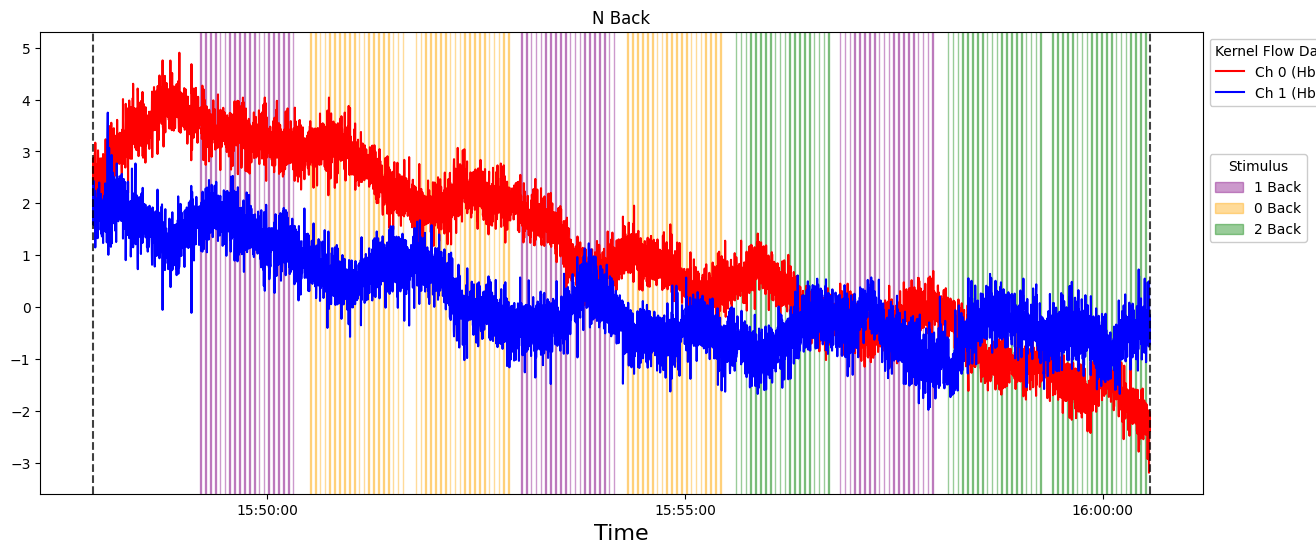

In [43]:
par.plot_flow_exp("n_back")

In [38]:
print(par.par_behav .exp_order)
print(datetime.datetime.fromtimestamp(par.par_behav.king_devick.start_ts))
session = par.par_behav.get_key_from_value(par.par_behav.session_dict, "king_devick")
print(par.get_time_offset("king_devick"))
par.flow_session_dict[session].get_time_abs("datetime")

['resting_state', 'go_no_go', 'video_narrative_sherlock', 'king_devick', 'vSAT', 'audio_narrative', 'n_back', 'tower_of_london', 'video_narrative_cmiyc']
2022-06-15 15:18:28.087190
11.980223417282104


array([datetime.datetime(2022, 6, 15, 15, 18, 25, 50781),
       datetime.datetime(2022, 6, 15, 15, 18, 25, 190863),
       datetime.datetime(2022, 6, 15, 15, 18, 25, 330945), ...,
       datetime.datetime(2022, 6, 15, 15, 37, 59, 779875),
       datetime.datetime(2022, 6, 15, 15, 37, 59, 919957),
       datetime.datetime(2022, 6, 15, 15, 38, 0, 60039)], dtype=object)

In [39]:
# par_num = 1
# exp_name = "n_back"
# exp_results = load_results(results_dir, exp_name, par_num)
# flow_exp = par.load_flow_exp(exp_name)
# session = par.par_behav.get_key_from_value(
#     par.par_behav.session_dict, exp_name
# )
# ts_list = par.flow_session_dict[session].get_time_abs("timestamp")
# data_fun = Data_Functions()
# blocks = list(exp_results["block"].unique())
# exp_baseline_avg_dict = {block: [] for block in blocks}  # initialize with unique blocks
# for _, row in exp_results.iterrows():
#     stim_start_ts = row["stim_start"]
#     start_idx, _ = data_fun.find_closest_ts(stim_start_ts, ts_list)
#     stim_end_ts = row["stim_end"]
#     end_idx, _ = data_fun.find_closest_ts(stim_end_ts, ts_list)
    
#     baseline_row = flow_exp.loc[start_idx, 0:]
#     stim_rows = flow_exp.loc[start_idx:end_idx, 0:]
#     avg_norm_rows = (stim_rows - baseline_row).mean()  # all channels for a stim
#     exp_baseline_avg_dict[row["block"]].append(avg_norm_rows)  # add to block in dict

In [40]:
ts_list = par.flow_session_dict["session_1003"].get_time_abs("timestamp")
stim_start_ts = exp_results.loc[exp_results['participant'] == par_num, 'stim_start'].values[0]  # TODO
stim_end_ts = exp_results.loc[exp_results['participant'] == par_num, 'stim_end'].values[0]  # TODO

data_fun = Data_Functions()
start_idx, _ = data_fun.find_closest_ts(stim_start_ts, ts_list)
end_idx, _ = data_fun.find_closest_ts(stim_end_ts, ts_list)

flow_exp = par.load_flow_exp(exp_name="n_back")
baseline_row = flow_exp.loc[start_idx, 0:]
stim_rows = flow_exp.loc[start_idx:end_idx, 0:]
avg_rows = (stim_rows - baseline_row).mean()
avg_rows


# for each participant
    # for each experiment
        # for each block (all blocks, not just unique)
            # for each channel

Exception: No valid timestamp found.

In [ ]:
stim_rows - baseline_row

,0,1,2,3,4,5,6,7,8,9,...,4282,4283,4284,4285,4286,4287,4288,4289,4290,4291
484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
485,-0.2421,0.244921,-0.492068,0.346133,-0.032427,0.067382,-0.663969,0.392208,-0.363832,0.501474,...,0.892068,-0.599874,-0.174531,0.293438,-0.034588,0.248709,-0.726824,0.644045,0.560967,-0.587296
486,-0.023641,-0.297637,-0.203,-0.331453,0.727243,-0.659046,-0.172061,-0.357354,0.097989,-0.357402,...,0.382719,-0.268239,-0.008279,-0.366309,0.177833,-0.299284,0.204685,-0.126273,1.114826,-1.420502
487,-0.251958,0.19241,-0.33202,0.15367,0.173729,-0.204061,-0.28396,0.111158,-0.367817,-0.073594,...,0.23063,0.203858,0.103599,0.404452,0.291764,0.002978,0.634647,-0.637705,0.95912,-0.599843


In [ ]:
from statistics import mean
mean([-.2421, -0.023641, -0.251958, 0])

-0.12942475

In [ ]:
print(f"Experiment order: {par.par_behav.exp_order}\n")

exp_name = "resting_state"
exp = par.par_behav.get_exp(exp_name)
exp_time_origin_ts = exp.start_ts
exp_time_origin_dt = datetime.datetime.fromtimestamp(exp_time_origin_ts)
print(f"Experiment time origin: {exp_time_origin_dt}")
start_marker_sent_time = float(exp.marker_data["start_marker"]["sent_time"])
print(f"Start marker sent time: {start_marker_sent_time}")
start_marker_sent_time_abs = exp_time_origin_dt + datetime.timedelta(seconds=start_marker_sent_time)
print(f"Start marker sent time (absolute): {start_marker_sent_time_abs}")

# The behavioral start marker sent time (absolute) and 
# kernel start marker receive time (absolute) should be identical.

flow_time_origin = par.flow_session_dict["session_1001"].get_time_origin(offset=False)
print(f"Flow time origin: {flow_time_origin}\n")
session = par.par_behav.get_key_from_value(par.par_behav.session_dict, exp_name)
marker_df = par.flow_session_dict[session].get_marker_df()
print(f"Kernel marker data (original):\n{marker_df}\n")
marker_df_abs = par.create_abs_marker_df(session)
print(f"Kernel marker data (absolute):\n{marker_df_abs}")

row = marker_df_abs.loc[marker_df_abs["Marker"].str.startswith(exp_name)].reset_index()
kernel_start_marker_ts = row.loc[0, "Start timestamp"]
time_offset = kernel_start_marker_ts - (exp_time_origin_ts + start_marker_sent_time)
print(f"\nTime offset: {round(time_offset, 3)}")

Experiment order: ['resting_state', 'go_no_go', 'video_narrative_sherlock', 'king_devick', 'vSAT', 'audio_narrative', 'n_back', 'tower_of_london', 'video_narrative_cmiyc']

Experiment time origin: 2022-06-15 14:43:17.132986
Start marker sent time: 11.6911
Start marker sent time (absolute): 2022-06-15 14:43:28.824086
Flow time origin: 2022-06-15 18:43:22

Kernel marker data (original):
     Timestamp    Duration  Value  Experiment
0    19.105127  441.473551    1.0        51.0
1  1120.861606  514.570869    1.0        81.0

Kernel marker data (absolute):
                           Marker  Start timestamp    Duration  End timestamp
0             resting_state_start     1.655319e+09  441.473551   1.655319e+09
1  video_narrative_sherlock_start     1.655320e+09  514.570869   1.655320e+09

Time offset: 12.281


In [ ]:
# Time offset issue
# Kernel Flow PC - Behavioral Task PC
par_num = 1
par = Participant_Flow(par_num)
time_offset_list = []
print("Time difference:\n------------")
for exp_name in par.par_behav.exp_order:
    try:
        time_offset = round(par.get_time_offset(exp_name), 3)
        time_offset_list.append(time_offset)
        print(f"{time_offset}, {exp_name}")
    except:
        pass

Time difference:
------------
12.281, resting_state
12.285, video_narrative_sherlock
11.98, king_devick
11.981, vSAT
11.983, audio_narrative
12.577, n_back
12.58, tower_of_london
12.582, video_narrative_cmiyc


In [ ]:
import numpy as np
from scipy.signal import firwin, lfilter

# Define the filter parameters
order = 20
fs = 1.0  # Sampling frequency (Hz)
cutoff = 0.1  # Cut-off frequency (Hz)

# Design the filter coefficients using the firwin function
nyq = 0.5 * fs
taps = firwin(order + 1, cutoff/nyq)

# Generate a signal
t = par.flow_session_dict["session_1001"].get_time_abs("datetime")[0:11000]
x = par.flow_session_dict["session_1001"].get_data("array", 0)[0:11000]

# Apply the filter using the lfilter function
y = lfilter(taps, 1.0, x)

# Plot the original and filtered signals
import matplotlib.pyplot as plt
plt.plot(t, x, 'b-', linewidth=1, alpha=0.5, label='Unfiltered signal')
plt.plot(t, y, 'r-', linewidth=2, label='Filtered signal')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


TypeError: float() argument must be a string or a real number, not 'datetime.datetime'